In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
path =  Path(os.path.abspath("")).parent.absolute()
print(path)
sys.path.append(path)
save_folder = os.path.join(path, 'figures/')
import pickle
import matplotlib.pyplot as plt
import copy
import torch
from datetime import timedelta, datetime
import matplotlib.dates as mdates

import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os
import GAMCR

def filter_dates(dates, site, all_data=False):
    dates = pd.to_datetime(dates)
    if not(all_data):
        idxsyear = np.where(np.array([date.year for date in dates])>=2018)[0]
    if site == '46':
        low_month = 7
        up_month = 9
    elif site in ['3','44','112']:
        low_month = 6
        up_month = 10
    else:
        low_month = 5
        up_month = 10
    idxsmonth_low = np.where(np.array([date.month for date in dates])>=low_month)[0]
    #np.where(dates.apply(lambda x: x.month>=low_month))[0]
    #idxsmonth_up = np.where(dates.apply(lambda x: x.month<=up_month))[0]
    idxsmonth_up = np.where(np.array([date.month for date in dates])<=up_month)[0]
    if not(all_data):
        idxs = np.intersect1d(idxsyear, idxsmonth_low)
    else:
        idxs = idxsmonth_low
    idxs = np.intersect1d(idxs, idxsmonth_up)
    return idxs


def nse(observed, simulated):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE).
    
    Parameters:
    observed (array-like): Array of observed values.
    simulated (array-like): Array of simulated values.
    
    Returns:
    float: NSE value.
    """
    observed = np.array(observed)
    simulated = np.array(simulated)
    
    # Calculate the mean of the observed data
    mean_observed = np.mean(observed)
    
    # Compute the numerator and denominator of the NSE formula
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    
    # Compute NSE
    nse_value = 1 - (numerator / denominator)
    
    return nse_value


import matplotlib.cm as cm
import colorsys
def rainbow_colors(K = 10):
    colors = cm.rainbow(np.linspace(0, 1, K))
    # Reduce brightness by converting RGB to HSV and adjusting Value (V)
    adjusted_colors = []
    for color in colors:
        r, g, b, _ = color
        h, s, v = colorsys.rgb_to_hsv(r, g, b)
        v = v * 0.7  # Reduce brightness to 70% of original
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        adjusted_colors.append((r, g, b))
    return adjusted_colors


log_mode = False

from get_data_from_ERRA import *
path_ERRA = os.path.join(path, 'data_and_visualization', 'output_ERRA_forGAMCR')
dicERRA = get_data_from_ERRA(path_ERRA)
#all_GISID = list(dicERRA.keys())
all_GISID = [el for el in list(os.walk(path))[0][1] if not any(c in el for c in ['/', '.', '_'])]
colors = rainbow_colors(len(all_GISID))

/home/duchemin/Documents/GAMCR/experiments/real_data


In [2]:
# import pandas as pd
# import numpy as np
# import sys
# from joblib import Parallel, delayed
# sys.path.append('/mydata/watres/quentin/code/FLOW/hourly_analysis/')
# import GAMCR
# data_folder = '/mydata/watres/quentin/code/FLOW/hourly_analysis/RES_GAMCR/real_data_paper_v2_seasonal/'
# import os
# import pickle
# import matplotlib.pyplot as plt
# import copy
# import torch

# all_data = True



GISID2name = {'48':'Sonceboz',
              '44':'Euthal',
               '50':'Salmsach',
               '58':'Chiasso',
               '88':'Magliaso',
               '112':'Lavertezzo'
             }
                

# Showing weighted avg RRD without last bin of precipitation and NRF peak height stratifying by precipitation intensity

In [3]:
def filter_dates(dates, all_data=False):
    dates = pd.to_datetime(dates)
    if not(all_data):
        idxsyear = np.where(np.array([date.year for date in dates])<2018)[0]
    if site == '46':
        low_month = 7
        up_month = 9
    elif site in ['3','44','112']:
        low_month = 6
        up_month = 10
    else:
        low_month = 5
        up_month = 10
    idxsmonth_low = np.where(np.array([date.month for date in dates])>=low_month)[0]
    #np.where(dates.apply(lambda x: x.month>=low_month))[0]
    #idxsmonth_up = np.where(dates.apply(lambda x: x.month<=up_month))[0]
    idxsmonth_up = np.where(np.array([date.month for date in dates])<=up_month)[0]
    if not(all_data):
        idxs = np.intersect1d(idxsyear, idxsmonth_low)
    else:
        idxs = idxsmonth_low
    idxs = np.intersect1d(idxs, idxsmonth_up)
    return idxs
    
def show_tf_without_last_bin(site_folder, site, stratif_wetness=False, weighted=True, show_CI=True, alpha=0.1, maxT=None, dataERRA=None, figname=None):
    folder = os.path.join(site_folder, "results", "detailedresults")
    NRF_avg = np.load(os.path.join(folder, 'NRF_avg.npy'))
    RRD_avg = np.load(os.path.join(folder, 'RRD_avg.npy'))
    m = RRD_avg.shape[1]
    
    with open(os.path.join(folder, 'groups_precip.pkl'), 'rb') as handle:
        groups_precip = pickle.load(handle)
        nJ = len(groups_precip)
    with open(os.path.join(folder, 'groups_wetness.pkl'), 'rb') as handle:
        groups_wetness = pickle.load(handle)
        nQ = len(groups_wetness)
        
    with open(os.path.join(folder, 'group2p_range.pkl'), 'rb') as handle:
        group2p_range = pickle.load(handle)
    with open(os.path.join(folder, 'group2q_range.pkl'), 'rb') as handle:
        group2q_range = pickle.load(handle)
    with open(os.path.join(folder, 'group2nbpoints.pkl'), 'rb') as handle:
        group2nbpoints = pickle.load(handle)

    if stratif_wetness:
        K = nQ
    else:
        K = nJ
    try:
        NRF_avg_true = np.load(os.path.join(folder, 'NRF_avg_true.npy'))
        RRD_avg_true = np.load(os.path.join(folder, 'RRD_avg_true.npy'))
        with open(os.path.join(folder, 'group2nbpoints_true.pkl'), 'rb') as handle:
            group2nbpoints_true = pickle.load(handle)
        true_tfs = True
        tf_true = np.zeros((K,m))
        norm_true = np.zeros(K)
    except:
        true_tfs = False
        pass

    if maxT is None:
        maxT = m
    if not(dataERRA is None):
        maxT = int(np.max(dataERRA['lagtime']))
    x = np.arange(0,maxT,1)/24
    #colors = ['red', 'orange', 'green', 'cyan', 'blue']
    from matplotlib.pyplot import cm
    colors = rainbow_colors(K)
    tf = np.zeros((K,m))
    norm = np.zeros(K)
    idx2legends = ['' for k in range(K)]

    quantile2meanJ = np.zeros(nJ-1)
    df = pd.read_csv(os.path.join(site_folder, f'data_{site}.txt'))
    for j in range(nJ-1):
        low,up = group2p_range[nQ*j]
        J_j = df['p'][df['p'].apply(lambda x: (x>=low) and (x<=up))]
        quantile2meanJ[j] = np.mean(J_j)
        
    
    for j in range(nJ):
        for k in range(nQ):
            if stratif_wetness:
                idx = k
                low,up = np.round(group2q_range[nQ*j+k], 3)
                upleg = up if idx!=(nQ-1) else 'max'
                idx2legends[idx] = '{0}-{1}'.format(low,upleg)
                tit_legend = 'Antecedent wetness'
            else:
                idx = j
                low,up = np.round(group2p_range[nQ*j+k], 1)
                upleg = up if idx!=(nJ-1) else 'max'
                idx2legends[idx] = '{0}-{1}'.format(low,upleg)
                tit_legend = 'Precipitation intensity'


            if group2nbpoints[nQ*j+k]>1:
                norm[idx] += group2nbpoints[nQ*j+k]
                tf[idx,:] += NRF_avg[nQ*j+k,:] * group2nbpoints[nQ*j+k]
            if true_tfs:
                if group2nbpoints_true[nQ*j+k]>1:
                    norm_true[idx] += group2nbpoints_true[nQ*j+k]
                    tf_true[idx,:] += NRF_avg_true[nQ*j+k,:] * group2nbpoints_true[nQ*j+k]
    for idx in range(K):
        tf[idx,:] /= norm[idx]

    df = pd.read_csv(os.path.join(site_folder, f'data_{site}.txt'))
    WRRD_GAMCR = np.zeros(tf.shape[1])
    WRRD_ERRA = np.zeros(dataERRA['group2NRF'].shape[1])

    idxs = filter_dates(df['date'], all_data=True)
    for j in range(nJ):
        WRRD_GAMCR +=  norm[j] * tf[j,:]
        WRRD_ERRA += norm[j] * dataERRA['group2NRF'][j,:]
    WRRD_GAMCR /= (np.sum(norm)*np.mean(df['p'].iloc[idxs]))
    WRRD_ERRA /= (np.sum(norm)*np.mean(df['p'].iloc[idxs]))
    return WRRD_GAMCR, WRRD_ERRA


In [4]:
os.getcwd()

'/home/duchemin/Documents/GAMCR/experiments/real_data/data_and_visualization'

In [5]:
WRRD_ERRA = {}
WRRD_GAMCR = {}
for site in all_GISID:
    site_folder = '../{0}/'.format(site)
    gamcr, erra = show_tf_without_last_bin(site_folder, site, weighted=True, dataERRA=dicERRA[site])
    WRRD_ERRA[site] = erra
    WRRD_GAMCR[site] = gamcr

In [6]:
def show_vs_precip_intensity(ax,global_path, all_sites, weighted=True, log_ordo=False, dataERRA=None, show_GAMCR=True, show_sites_labels=True, figsave=None, stats2show=None, results_name_folder='result'):
    if stats2show is None:
        stats2show = ['area', 'peak', 'mean', 'peaklag']
    site2tf = {}
    import math
    color_map = plt.cm.tab20  # Use tab20 colormap for distinct colors
    markers = {'GAMCR': 'o', 'ERRA': '^', 'true':'s' }  # Define markers for methods
    colors = [color_map(i / len(all_sites)) for i in range(len(all_sites))]  # Generate colors
    linestyle = {'GAMCR':'--', 'ERRA':'-.', 'true':'-'}

    id_site = 0

    site2area_esti = {}
    site2peak_esti = {}
    site2mean_esti = {}
    site2peaklag_esti = {}

    site2quantiles = {}
    
    site2area_esti_noweight = {}
    site2peak_esti_noweight = {}
    site2mean_esti_noweight = {}
    site2peaklag_esti_noweight = {}

    site2area_true = {}
    site2peak_true = {}
    site2mean_true = {}
    site2peaklag_true = {}

    site2quantiles_true = {}
    
    site2area_true_noweight = {}
    site2peak_true_noweight = {}
    site2mean_true_noweight = {}
    site2peaklag_true_noweight = {}

    for site in all_sites:
        folder = os.path.join(global_path, site, results_name_folder)

        NRF_avgbis = np.load(os.path.join(folder, 'NRF_avg.npy'))
        RRD_avgbis = np.load(os.path.join(folder, 'RRD_avg.npy'))
        m = RRD_avgbis.shape[1]
        
        with open(os.path.join(folder, 'groups_precip.pkl'), 'rb') as handle:
            groups_precip = pickle.load(handle)
            nJ = len(groups_precip)
        with open(os.path.join(folder, 'groups_wetness.pkl'), 'rb') as handle:
            groups_wetness = pickle.load(handle)
            nQ = len(groups_wetness)
        with open(os.path.join(folder, 'group2p_range.pkl'), 'rb') as handle:
            group2p_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2q_range.pkl'), 'rb') as handle:
            group2q_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2nbpoints.pkl'), 'rb') as handle:
            group2nbpoints = pickle.load(handle)

        group2means_precip = np.load(os.path.join(folder, 'group2means_precip.npy'))
        group2means_wetness = np.load(os.path.join(folder, 'group2means_wetness.npy'))


        K = nJ
        try:
            NRF_avgbis_true = np.load(os.path.join(folder, 'NRF_avg_true.npy'))
            RRD_avgbis_true = np.load(os.path.join(folder, 'RRD_avg_true.npy'))
            NRF_avg_true = np.zeros((K,m))
            RRD_avg_true = np.zeros((K,m))
            group2means_precip_true = np.load(os.path.join(folder, 'group2means_precip_true.npy'))
            group2means_wetness_true = np.load(os.path.join(folder, 'group2means_wetness_true.npy'))

            quantiles_precip_true = np.zeros(K)
            with open(os.path.join(folder, 'group2nbpoints_true.pkl'), 'rb') as handle:
                group2nbpoints_true = pickle.load(handle)
            true_tfs = True
            tf_true = np.zeros(m)
            norm_true = np.zeros(K)
        except:
            true_tfs = False
            linestyle['GAMCR'] = '-'
            linestyle['ERRA'] = '--'
            pass

        NRF_avg = np.zeros((K,m))
        RRD_avg = np.zeros((K,m))
        quantiles_precip = np.zeros(K)
        norm = np.zeros(K)
        for j in range(K):
            for k in range(nQ):
                idx = j
                if group2nbpoints[nQ*j+k]>1:
                    norm[idx] += group2nbpoints[nQ*j+k]
                    NRF_avg[idx,:] += NRF_avgbis[nQ*j+k,:] * group2nbpoints[nQ*j+k]
                    RRD_avg[idx,:] += RRD_avgbis[nQ*j+k,:] * group2nbpoints[nQ*j+k]
                    quantiles_precip[idx] += group2means_precip[nQ*j+k] * group2nbpoints[nQ*j+k]

                if true_tfs:
                    if group2nbpoints_true[nQ*j+k]>1:
                        norm_true[idx] += group2nbpoints_true[nQ*j+k]
                        NRF_avg_true[idx,:] += NRF_avgbis_true[nQ*j+k,:] * group2nbpoints_true[nQ*j+k]
                        RRD_avg_true[idx,:] += RRD_avgbis_true[nQ*j+k,:] * group2nbpoints_true[nQ*j+k]
                        quantiles_precip_true[idx] += group2means_precip_true[nQ*j+k] * group2nbpoints_true[nQ*j+k]
        for idx in range(K):
            NRF_avg[idx,:] /= norm[idx]
            quantiles_precip[idx] /= norm[idx]
            if true_tfs:
                NRF_avg_true[idx,:] /= norm_true[idx]
                quantiles_precip_true[idx] /= norm_true[idx]

        site2area_esti[site] = np.zeros(K)
        site2peak_esti[site] = np.zeros(K)
        site2mean_esti[site] = np.zeros(K)
        site2peaklag_esti[site] = np.zeros(K)

        site2area_esti_noweight[site] = np.zeros(K)
        site2peak_esti_noweight[site] = np.zeros(K)
        site2mean_esti_noweight[site] = np.zeros(K)
        site2quantiles[site] = quantiles_precip
        site2peaklag_esti_noweight[site] = np.zeros(K)

        for k in range(K):
            site2area_esti[site][k] = np.sum(NRF_avg[k,:])
            site2peak_esti[site][k] = np.max(NRF_avg[k,:])
            site2mean_esti[site][k] = np.sum(NRF_avg[k,:]*np.arange(m)/np.sum(NRF_avg[k,:]))
            site2peaklag_esti[site][k] = np.argmax(NRF_avg[k,:])

            site2area_esti_noweight[site][k] = np.sum(RRD_avg[k,:])
            site2peak_esti_noweight[site][k] = np.max(RRD_avg[k,:])
            site2mean_esti_noweight[site][k] = np.sum(RRD_avg[k,:]*np.arange(m)/np.sum(RRD_avg[k,:]))
            site2peaklag_esti_noweight[site][k] = np.argmax(RRD_avg[k,:])

        if true_tfs:
            
            site2area_true[site] = np.zeros(K)
            site2peak_true[site] = np.zeros(K)
            site2mean_true[site] = np.zeros(K)
            site2peaklag_true[site] = np.zeros(K)
    
            site2area_true_noweight[site] = np.zeros(K)
            site2peak_true_noweight[site] = np.zeros(K)
            site2mean_true_noweight[site] = np.zeros(K)
            site2quantiles_true[site] = quantiles_precip_true
            site2peaklag_true_noweight[site] = np.zeros(K)

            mtrue = NRF_avg_true.shape[1]
            for k in range(K):
                site2area_true[site][k] = np.sum(NRF_avg_true[k,:])
                site2peak_true[site][k] = np.max(NRF_avg_true[k,:])
                site2mean_true[site][k] = np.sum(NRF_avg_true[k,:]*np.arange(mtrue)/np.sum(NRF_avg_true[k,:]))
                site2peaklag_true[site][k] = np.argmax(NRF_avg_true[k,:])
    
                site2area_true_noweight[site][k] = np.sum(RRD_avg_true[k,:])
                site2peak_true_noweight[site][k] = np.max(RRD_avg_true[k,:])
                site2mean_true_noweight[site][k] = np.sum(RRD_avg_true[k,:]*np.arange(mtrue)/np.sum(RRD_avg_true[k,:]))
                site2peaklag_true_noweight[site][k] = np.argmax(RRD_avg_true[k,:])
    
    
    if true_tfs:
        if weighted:
            stats_true = {'area': site2area_true, 'peak': site2peak_true, 'peaklag': site2peaklag_true, 'mean':site2mean_true, 'quantiles':site2quantiles_true}
        else:
            stats_true = {'area': site2area_true_noweight, 'peak': site2peak_true_noweight, 'peaklag': site2peaklag_true_noweight, 'mean':site2mean_true_noweight, 'quantiles':site2quantiles_true}

    if weighted:
        stats_esti = {'area': site2area_esti, 'peak': site2peak_esti, 'peaklag': site2peaklag_esti, 'mean':site2mean_esti, 'quantiles':site2quantiles}    
        TF = 'NRF'
    else:
        stats_esti = {'area': site2area_esti_noweight, 'peak': site2peak_esti_noweight, 'peaklag': site2peaklag_esti_noweight, 'mean':site2mean_esti_noweight, 'quantiles':site2quantiles}
        TF = 'RRD'

    #markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H']

    stat2label = {'area': '{0} runoff volume'.format(TF),
                  'peak': '{0} peak height '.format(TF) + '($mm$ $h^{-2}$)',
                  'mean': '{0} mean lag'.format(TF),
                  'peaklag': '{0} peak lag'.format(TF)
                 }

    def get_stat_ERRA(group2nrf, group2se, lagtime, stat):
        from scipy.integrate import trapezoid
        from scipy.interpolate import interp1d
        group2stat = np.zeros(group2nrf.shape[0])
        group2low = np.zeros(group2nrf.shape[0])
        group2up = np.zeros(group2nrf.shape[0])
        f = 1.96 # to get 95% confidence intervals
        if stat == "area":
            for k in range(group2nrf.shape[0]):
                group2stat[k] = trapezoid(group2nrf[k,:], lagtime)
                group2low[k] = trapezoid(group2nrf[k,:]-f*group2se[k,:], lagtime)
                group2up[k] = trapezoid(group2nrf[k,:]+f*group2se[k,:], lagtime)
        elif stat == "peak":
            for k in range(group2nrf.shape[0]):
                idx = np.argmax(group2nrf[k,:])
                group2stat[k] = group2nrf[k,idx]
                group2low[k] = group2nrf[k,idx]+f*group2se[k,idx]
                group2up[k] = group2nrf[k,idx]-f*group2se[k,idx]
        elif stat == "mean":
            for k in range(group2nrf.shape[0]):
                # Step 1: Interpolate y(x) with a finer grid
                x_fine = np.linspace(lagtime[0], lagtime[-1], m)  # Choose a finer grid
                interpolator = interp1d(lagtime, group2nrf[k,:], kind='cubic')  # 'cubic' for smooth interpolation
                y_fine = interpolator(x_fine)
                # Step 2: Compute the weighted integral
                weighted_y_fine = x_fine * y_fine
                weighted_y_fine /= np.sum(weighted_y_fine)
                group2stat[k] = np.sum(weighted_y_fine*x_fine)
        elif stat == "peaklag":
            for k in range(group2nrf.shape[0]):
                group2stat[k] = lagtime[np.argmax(group2nrf[k,:])]
        return group2stat, group2low, group2up

    for stat in stats2show:
        tickslabel = []
        count_fig = -1
        max_val = -float('inf')
        min_val = float('inf')
        for id_station,site in enumerate(all_sites):
                count_fig += 1
                K = len(stats_esti[stat][site])
                if log_ordo:
                    if show_GAMCR:
                        ax.scatter(stats_esti['quantiles'][site], np.log(stats_esti[stat][site]), marker=markers['GAMCR'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], np.log(stats_esti[stat][site]), linestyle=linestyle['GAMCR'], c=colors[id_station])
                    if true_tfs:
                        ax.scatter(stats_true['quantiles'][site], np.log(stats_true[stat][site]), marker=markers['true'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_true['quantiles'][site], np.log(stats_true[stat][site]),linestyle=linestyle['true'], c=colors[id_station])
                    if dataERRA != None:
                        erra_stats, erra_low, erra_up = get_stat_ERRA(dataERRA[site]['group2NRF'], dataERRA[site]['group2NRF_SE'], dataERRA[site]['lagtime'], stat)
                        #ax.scatter(stats_esti['quantiles'][site], np.log(erra_stats), marker=markers['ERRA'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], np.log(erra_stats), linestyle=linestyle['ERRA'],markersize=8,marker=markers['ERRA'],fillstyle='none',  c=colors[id_station])
                        #ax.fill_between(stats_esti['quantiles'][site], erra_low, erra_up, color=colors[id_station], alpha=0.4)
                else:
                    if show_GAMCR:
                        ax.scatter(stats_esti['quantiles'][site], stats_esti[stat][site], marker=markers['GAMCR'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], stats_esti[stat][site], linestyle=linestyle['GAMCR'], c=colors[id_station])
                    if true_tfs:
                        ax.scatter(stats_true['quantiles'][site], stats_true[stat][site], marker=markers['true'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_true['quantiles'][site], stats_true[stat][site],  linestyle=linestyle['true'], c=colors[id_station])
                    if dataERRA != None:
                        erra_stats, erra_low, erra_up = get_stat_ERRA(dataERRA[site]['group2NRF'], dataERRA[site]['group2NRF_SE'], dataERRA[site]['lagtime'], stat)
                        #ax.scatter(stats_esti['quantiles'][site], erra_stats, marker=markers['ERRA'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], erra_stats, linestyle=linestyle['ERRA'],markersize=8,  marker=markers['ERRA'], fillstyle='none', c=colors[id_station])
                        #ax.fill_between(stats_esti['quantiles'][site], erra_low, erra_up, color=colors[id_station], alpha=0.4)
        
        title = stat



        # Add the GISID color blocks to the 
        if False:
            legend_patches = []
            for ii, GISID in enumerate(all_sites):
                legend_patches.append(Patch(facecolor=colors[ii], edgecolor='black', label=GISID2name[GISID]))
    
    
    
            gisid_legend = ax.legend(handles=legend_patches, loc='lower right', title='Sites', fontsize=11, title_fontsize=13)
            
            method_legend_lines = [
                Line2D([0], [0], color='black', lw=linewidth, marker=markers['GAMCR'], label='GAMCR'),
                Line2D([0], [0], color='black', linestyle='--', lw=linewidth, fillstyle='none', marker=markers['ERRA'], label='ERRA')
            ]
            method_legend = ax.legend(handles=method_legend_lines, loc='upper left', fontsize=11, title="Methods", title_fontsize=13)
    
            ax.add_artist(gisid_legend)  # Add GISID legend manually so it doesn't get overwritten




        if show_GAMCR:
            title += '_GAMCR'
            plt.plot([],[], color='black', linestyle=linestyle['GAMCR'], marker=markers['GAMCR'], label='GAMCR')
        if true_tfs:
            plt.plot([],[], color='black', linestyle=linestyle['true'],  marker=markers['true'],label='Ground truth')
        if dataERRA != None:
            title += '_ERRA'
            plt.plot([],[], color='black', linestyle=linestyle['ERRA'], marker=markers['ERRA'], label='ERRA')

#        plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize='small', title='Site')

        plt.xlabel('Precipitation ($mm$ $h^{-1}$)', fontsize=14)
        if log_ordo:
            plt.ylabel('Log( {0} )'.format(stat2label[stat]), fontsize=14)
        else:
            plt.ylabel(stat2label[stat], fontsize=14)

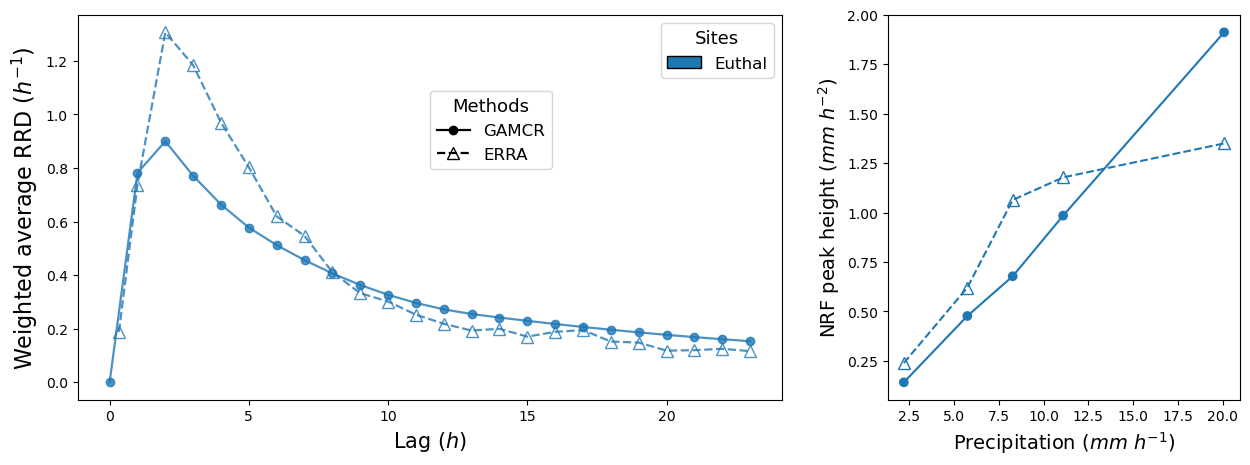

In [9]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 2,  gridspec_kw={'width_ratios': [2, 1]}, figsize=(15, 5))


linewidth = 1.6
color_map = plt.cm.tab20  # Use tab20 colormap for distinct colors
markers = {'GAMCR': 'o', 'ERRA': '^'}  # Define markers for methods
colors = [color_map(i / len(all_GISID)) for i in range(len(all_GISID))]  # Generate colors

# Create legend patches for GISIDs
legend_patches = []

for method in ['GAMCR', 'ERRA']:
    for ii, GISID in enumerate(all_GISID):
        
        ########## Transfer functions
        maxlag = int(24 * 1)
        lagsERRA = dicERRA[GISID]['lagtime_RRD']
        if lagsERRA[-1] <= maxlag:
            idx_erra = len(lagsERRA)
        else:
            idx_erra = np.where(lagsERRA <= maxlag)[0][-1]

        # Plot the curves with unique colors per GISID and method-specific styles
        if log_mode:
            if method == 'GAMCR':
                axs[0].plot([i  for i in range(maxlag)], np.log(WRRD_GAMCR[GISID][:maxlag]), 
                         color=colors[ii], lw=1.3, marker=markers[method], alpha=0.8)
            else:
                axs[0].plot(dicERRA[GISID]['lagtime_RRD'][:idx_erra] , 
                         np.log(WRRD_ERRA[GISID][:idx_erra]), 
                         color=colors[ii], lw=0.9, linestyle='--', fillstyle='none', marker=markers[method], markersize=8, alpha=0.8)
        else:
            if method == 'GAMCR':
                axs[0].plot([i  for i in range(maxlag)], WRRD_GAMCR[GISID][:maxlag], 
                         color=colors[ii], lw=linewidth, marker=markers[method], alpha=0.8)
            else:
                axs[0].plot(dicERRA[GISID]['lagtime_RRD'][:idx_erra] , 
                         WRRD_ERRA[GISID][:idx_erra], 
                         color=colors[ii], linestyle='--', lw=linewidth, fillstyle='none', marker=markers[method], markersize=8, alpha=0.8)
        
        # Add a patch for each GISID if not already added
        if len(legend_patches) < len(all_GISID):
            legend_patches.append(Patch(facecolor=colors[ii], edgecolor='black', label=GISID2name[GISID]))



axs[0].set_xlabel('Lag ($h$)', fontsize=15)
axs[0].set_ylabel('Weighted average RRD ($h^{-1}$)', fontsize=16)

# Add the GISID color blocks to the legend
gisid_legend = axs[0].legend(handles=legend_patches, loc='upper right',  title='Sites', fontsize=12, title_fontsize=13)

method_legend_lines = [
    Line2D([0], [0], color='black', lw=linewidth, marker=markers['GAMCR'], label='GAMCR'),
    Line2D([0], [0], color='black', linestyle='--', lw=linewidth, fillstyle='none',markersize=8, marker=markers['ERRA'], label='ERRA')
]
method_legend = axs[0].legend(handles=method_legend_lines, loc=(0.5,0.6), fontsize=12, title="Methods", title_fontsize=13)
axs[0].add_artist(gisid_legend)  # Add GISID legend manually so it doesn't get overwritten


mode = 'training'
results_name_folder = 'results/detailedresults/'.format(site)
show_vs_precip_intensity(axs[1], path, all_GISID, weighted=True, log_ordo=False, dataERRA=dicERRA, show_GAMCR=True, stats2show=['peak'], figsave=os.path.join(path, 'NRF_peak.png'), results_name_folder=results_name_folder)
#plt.savefig(os.path.join(path, 'all_sites_rrd_nrf.png'), dpi=200, bbox_inches='tight')

# RRD peak height VS precipitation intensity

In [10]:
def show_vs_precip(ax,global_path, all_sites, weighted=True, log_ordo=False,markersize=10, dataERRA=None, show_GAMCR=True, show_sites_labels=True, figsave=None, stats2show=None, results_name_folder='result'):
    if stats2show is None:
        stats2show = ['area', 'peak', 'mean', 'peaklag']
    site2tf = {}
    import math
    color_map = plt.cm.tab20  # Use tab20 colormap for distinct colors
    markers = ['o','^','s',"P",'*']
    colors = [color_map(i / len(all_sites)) for i in range(len(all_sites))]  # Generate colors
    linestyle = {'GAMCR':'--', 'ERRA':'-.', 'true':'-'}
    id_site = 0

    site2area_esti = {}
    site2peak_esti = {}
    site2mean_esti = {}
    site2peaklag_esti = {}

    site2quantiles = {}
    
    site2area_esti_noweight = {}
    site2peak_esti_noweight = {}
    site2mean_esti_noweight = {}
    site2peaklag_esti_noweight = {}

    site2area_true = {}
    site2peak_true = {}
    site2mean_true = {}
    site2peaklag_true = {}

    site2quantiles_true = {}
    
    site2area_true_noweight = {}
    site2peak_true_noweight = {}
    site2mean_true_noweight = {}
    site2peaklag_true_noweight = {}

    for site in all_sites:
        folder = os.path.join(global_path, site, results_name_folder)

        NRF_avgbis = np.load(os.path.join(folder, 'NRF_avg.npy'))
        RRD_avgbis = np.load(os.path.join(folder, 'RRD_avg.npy'))
        m = RRD_avgbis.shape[1]
        
        with open(os.path.join(folder, 'groups_precip.pkl'), 'rb') as handle:
            groups_precip = pickle.load(handle)
            nJ = len(groups_precip)
        with open(os.path.join(folder, 'groups_wetness.pkl'), 'rb') as handle:
            groups_wetness = pickle.load(handle)
            nQ = len(groups_wetness)
        with open(os.path.join(folder, 'group2p_range.pkl'), 'rb') as handle:
            group2p_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2q_range.pkl'), 'rb') as handle:
            group2q_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2nbpoints.pkl'), 'rb') as handle:
            group2nbpoints = pickle.load(handle)

        group2means_precip = np.load(os.path.join(folder, 'group2means_precip.npy'))
        group2means_wetness = np.load(os.path.join(folder, 'group2means_wetness.npy'))


        K = nJ
        try:
            NRF_avgbis_true = np.load(os.path.join(folder, 'NRF_avg_true.npy'))
            RRD_avgbis_true = np.load(os.path.join(folder, 'RRD_avg_true.npy'))
            NRF_avg_true = np.zeros((K,m))
            RRD_avg_true = np.zeros((K,m))
            group2means_precip_true = np.load(os.path.join(folder, 'group2means_precip_true.npy'))
            group2means_wetness_true = np.load(os.path.join(folder, 'group2means_wetness_true.npy'))

            quantiles_precip_true = np.zeros(K)
            with open(os.path.join(folder, 'group2nbpoints_true.pkl'), 'rb') as handle:
                group2nbpoints_true = pickle.load(handle)
            true_tfs = True
            tf_true = np.zeros(m)
            norm_true = np.zeros(K)
        except:
            true_tfs = False
            linestyle['GAMCR'] = '-'
            linestyle['ERRA'] = '--'
            pass

        NRF_avg = np.zeros((K,m))
        RRD_avg = np.zeros((K,m))
        quantiles_precip = np.zeros(K)
        norm = np.zeros(K)
        for j in range(K):
            for k in range(nQ):
                idx = j
                if group2nbpoints[nQ*j+k]>1:
                    norm[idx] += group2nbpoints[nQ*j+k]
                    NRF_avg[idx,:] += NRF_avgbis[nQ*j+k,:] * group2nbpoints[nQ*j+k]
                    RRD_avg[idx,:] += RRD_avgbis[nQ*j+k,:] * group2nbpoints[nQ*j+k]
                    quantiles_precip[idx] += group2means_precip[nQ*j+k] * group2nbpoints[nQ*j+k]

                if true_tfs:
                    if group2nbpoints_true[nQ*j+k]>1:
                        norm_true[idx] += group2nbpoints_true[nQ*j+k]
                        NRF_avg_true[idx,:] += NRF_avgbis_true[nQ*j+k,:] * group2nbpoints_true[nQ*j+k]
                        RRD_avg_true[idx,:] += RRD_avgbis_true[nQ*j+k,:] * group2nbpoints_true[nQ*j+k]
                        quantiles_precip_true[idx] += group2means_precip_true[nQ*j+k] * group2nbpoints_true[nQ*j+k]
        for idx in range(K):
            NRF_avg[idx,:] /= norm[idx]
            RRD_avg[idx,:] /= norm[idx]
            quantiles_precip[idx] /= norm[idx]
            if true_tfs:
                NRF_avg_true[idx,:] /= norm_true[idx]
                RRD_avg_true[idx,:] /= norm_true[idx]
                quantiles_precip_true[idx] /= norm_true[idx]

        site2area_esti[site] = np.zeros(K)
        site2peak_esti[site] = np.zeros(K)
        site2mean_esti[site] = np.zeros(K)
        site2peaklag_esti[site] = np.zeros(K)

        site2area_esti_noweight[site] = np.zeros(K)
        site2peak_esti_noweight[site] = np.zeros(K)
        site2mean_esti_noweight[site] = np.zeros(K)
        site2quantiles[site] = quantiles_precip
        site2peaklag_esti_noweight[site] = np.zeros(K)

        for k in range(K):
            site2area_esti[site][k] = np.sum(NRF_avg[k,:])
            site2peak_esti[site][k] = np.max(NRF_avg[k,:])
            site2mean_esti[site][k] = np.sum(NRF_avg[k,:]*np.arange(m)/np.sum(NRF_avg[k,:]))
            site2peaklag_esti[site][k] = np.argmax(NRF_avg[k,:])

            site2area_esti_noweight[site][k] = np.sum(RRD_avg[k,:])
            site2peak_esti_noweight[site][k] = np.max(RRD_avg[k,:])
            site2mean_esti_noweight[site][k] = np.sum(RRD_avg[k,:]*np.arange(m)/np.sum(RRD_avg[k,:]))
            site2peaklag_esti_noweight[site][k] = np.argmax(RRD_avg[k,:])

        if true_tfs:
            
            site2area_true[site] = np.zeros(K)
            site2peak_true[site] = np.zeros(K)
            site2mean_true[site] = np.zeros(K)
            site2peaklag_true[site] = np.zeros(K)
    
            site2area_true_noweight[site] = np.zeros(K)
            site2peak_true_noweight[site] = np.zeros(K)
            site2mean_true_noweight[site] = np.zeros(K)
            site2quantiles_true[site] = quantiles_precip_true
            site2peaklag_true_noweight[site] = np.zeros(K)

            mtrue = NRF_avg_true.shape[1]
            for k in range(K):
                site2area_true[site][k] = np.sum(NRF_avg_true[k,:])
                site2peak_true[site][k] = np.max(NRF_avg_true[k,:])
                site2mean_true[site][k] = np.sum(NRF_avg_true[k,:]*np.arange(mtrue)/np.sum(NRF_avg_true[k,:]))
                site2peaklag_true[site][k] = np.argmax(NRF_avg_true[k,:])
    
                site2area_true_noweight[site][k] = np.sum(RRD_avg_true[k,:])
                site2peak_true_noweight[site][k] = np.max(RRD_avg_true[k,:])
                site2mean_true_noweight[site][k] = np.sum(RRD_avg_true[k,:]*np.arange(mtrue)/np.sum(RRD_avg_true[k,:]))
                site2peaklag_true_noweight[site][k] = np.argmax(RRD_avg_true[k,:])
    
    
    if true_tfs:
        if weighted:
            stats_true = {'area': site2area_true, 'peak': site2peak_true, 'peaklag': site2peaklag_true, 'mean':site2mean_true, 'quantiles':site2quantiles_true}
        else:
            stats_true = {'area': site2area_true_noweight, 'peak': site2peak_true_noweight, 'peaklag': site2peaklag_true_noweight, 'mean':site2mean_true_noweight, 'quantiles':site2quantiles_true}

    if weighted:
        stats_esti = {'area': site2area_esti, 'peak': site2peak_esti, 'peaklag': site2peaklag_esti, 'mean':site2mean_esti, 'quantiles':site2quantiles}    
        TF = 'NRF'
    else:
        stats_esti = {'area': site2area_esti_noweight, 'peak': site2peak_esti_noweight, 'peaklag': site2peaklag_esti_noweight, 'mean':site2mean_esti_noweight, 'quantiles':site2quantiles}
        TF = 'RRD'

    #markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H']

    stat2label = {'area': '{0} runoff volume'.format(TF),
                  'peak': '{0} peak height '.format(TF) + '($mm$ $h^{-2}$)',
                  'mean': '{0} mean lag'.format(TF),
                  'peaklag': '{0} peak lag'.format(TF)
                 }

    def get_stat_ERRA(group2nrf, group2se, lagtime, stat):
        from scipy.integrate import trapezoid
        from scipy.interpolate import interp1d
        group2stat = np.zeros(group2nrf.shape[0])
        group2low = np.zeros(group2nrf.shape[0])
        group2up = np.zeros(group2nrf.shape[0])
        f = 1.96 # to get 95% confidence intervals
        if stat == "area":
            for k in range(group2nrf.shape[0]):
                group2stat[k] = trapezoid(group2nrf[k,:], lagtime)
                group2low[k] = trapezoid(group2nrf[k,:]-f*group2se[k,:], lagtime)
                group2up[k] = trapezoid(group2nrf[k,:]+f*group2se[k,:], lagtime)
        elif stat == "peak":
            for k in range(group2nrf.shape[0]):
                idx = np.argmax(group2nrf[k,:])
                group2stat[k] = group2nrf[k,idx]
                group2low[k] = group2nrf[k,idx]+f*group2se[k,idx]
                group2up[k] = group2nrf[k,idx]-f*group2se[k,idx]
        elif stat == "mean":
            for k in range(group2nrf.shape[0]):
                # Step 1: Interpolate y(x) with a finer grid
                x_fine = np.linspace(lagtime[0], lagtime[-1], m)  # Choose a finer grid
                interpolator = interp1d(lagtime, group2nrf[k,:], kind='cubic')  # 'cubic' for smooth interpolation
                y_fine = interpolator(x_fine)
                # Step 2: Compute the weighted integral
                weighted_y_fine = x_fine * y_fine
                weighted_y_fine /= np.sum(weighted_y_fine)
                group2stat[k] = np.sum(weighted_y_fine*x_fine)
        elif stat == "peaklag":
            for k in range(group2nrf.shape[0]):
                group2stat[k] = lagtime[np.argmax(group2nrf[k,:])]
        return group2stat, group2low, group2up

    for stat in stats2show:
        tickslabel = []
        count_fig = -1
        max_val = -float('inf')
        min_val = float('inf')
        for id_station,site in enumerate(all_sites):
                count_fig += 1
                K = len(stats_esti[stat][site])
                if log_ordo:
                    if show_GAMCR:
                        ax.scatter(stats_esti['quantiles'][site], np.log(stats_esti[stat][site]), marker=markers['GAMCR'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], np.log(stats_esti[stat][site]), linestyle=linestyle['GAMCR'], c=colors[id_station])
                    if true_tfs:
                        ax.scatter(stats_true['quantiles'][site], np.log(stats_true[stat][site]), marker=markers['true'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_true['quantiles'][site], np.log(stats_true[stat][site]),linestyle=linestyle['true'], c=colors[id_station])
                    if dataERRA != None:
                        erra_stats, erra_low, erra_up = get_stat_ERRA(dataERRA[site]['group2NRF'], dataERRA[site]['group2NRF_SE'], dataERRA[site]['lagtime'], stat)
                        #ax.scatter(stats_esti['quantiles'][site], np.log(erra_stats), marker=markers['ERRA'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], np.log(erra_stats), linestyle=linestyle['ERRA'],markersize=8,marker=markers['ERRA'],fillstyle='none',  c=colors[id_station])
                        ax.fill_between(stats_esti['quantiles'][site], erra_low, erra_up, color=colors[id_station], alpha=0.4)
                else:
                    if show_GAMCR:
                        ax.scatter(stats_esti['quantiles'][site], stats_esti[stat][site], marker=markers[0], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], stats_esti[stat][site], c=colors[id_station])
                        #ax.scatter(stats_esti['quantiles'][site], stats_esti[stat][site], linestyle=linestyle['GAMCR'], c=colors[id_station])
                    if true_tfs:
                        ax.scatter(stats_true['quantiles'][site], stats_true[stat][site], marker=markers['true'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_true['quantiles'][site], stats_true[stat][site],  linestyle=linestyle['true'], c=colors[id_station])
                    if dataERRA != None:
                        erra_stats, erra_low, erra_up = get_stat_ERRA(dataERRA[site]['group2NRF'], dataERRA[site]['group2NRF_SE'], dataERRA[site]['lagtime'], stat)
                        #ax.scatter(stats_esti['quantiles'][site], erra_stats, marker=markers['ERRA'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], erra_stats, linestyle=linestyle['ERRA'],markersize=8,  marker=markers['ERRA'], fillstyle='none', c=colors[id_station])
                        ax.fill_between(stats_esti['quantiles'][site], erra_low, erra_up, color=colors[id_station], alpha=0.4)
        
        title = stat

        plt.xlabel('Precipitation intensity ($mm$ $h^{-1}$)', fontsize=14)
        if log_ordo:
            plt.ylabel('Log( {0} )'.format(stat2label[stat]), fontsize=14)
        else:
            plt.ylabel(stat2label[stat], fontsize=14)

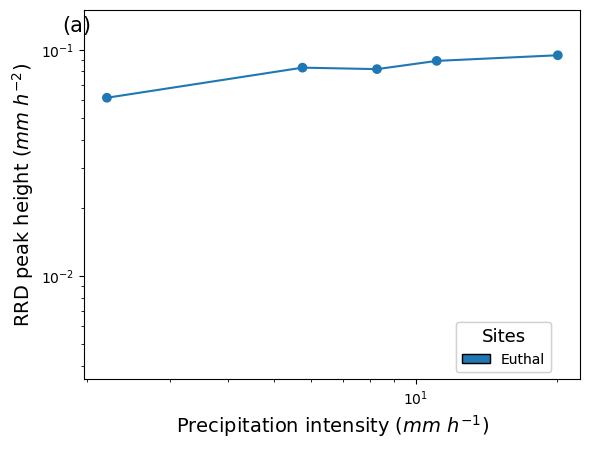

In [17]:
fig, axs = plt.subplots(1, 1)

weighted=False

results_name_folder = 'results/detailedresults/'.format(site)
show_vs_precip(axs, path, all_GISID, markersize=40, weighted=weighted, log_ordo=False, show_GAMCR=True, stats2show=['peak'], figsave=os.path.join(path, 'NRF_peak.png'), results_name_folder=results_name_folder)
if True:
    axs.text(1.77,0.12, '(a)', fontsize=15)
    axs.set_ylim(0.0035,0.15)
    axs.set_xscale('log')
    axs.set_yscale('log')
legend_patches = []
for ii, GISID in enumerate(all_GISID):
    if len(legend_patches) < len(all_GISID):
        legend_patches.append(Patch(facecolor=colors[ii], edgecolor='black', label=GISID2name[GISID]))

# Add the GISID color blocks to the legend
gisid_legend = axs.legend(handles=legend_patches,  loc=(0.75,0.02),  title='Sites', fontsize=10, title_fontsize=13)
axs.add_artist(gisid_legend)  # Add GISID legend manually so it doesn't get overwritten

plt.savefig(os.path.join(path, 'RRD_peak_precipintensity.png'), dpi=200, bbox_inches='tight')

# RRD peak height VS antecedent wetness

In [18]:
def show_vs_antecedent_wetness(ax,global_path, all_sites, filter_bin_precip=None, weighted=True, log_ordo=False,markersize=10, dataERRA=None, show_GAMCR=True, show_sites_labels=True, figsave=None, stats2show=None, results_name_folder='result'):
    if stats2show is None:
        stats2show = ['area', 'peak', 'mean', 'peaklag']
    site2tf = {}
    import math
    color_map = plt.cm.tab20  # Use tab20 colormap for distinct colors
    markers = ['o','^','s',"P",'*']
    colors = [color_map(i / len(all_sites)) for i in range(len(all_sites))]  # Generate colors
    linestyle = {'GAMCR':'--', 'ERRA':'-.', 'true':'-'}
    id_site = 0

    site2area_esti = {}
    site2peak_esti = {}
    site2mean_esti = {}
    site2peaklag_esti = {}

    site2quantiles = {}
    
    site2area_esti_noweight = {}
    site2peak_esti_noweight = {}
    site2mean_esti_noweight = {}
    site2peaklag_esti_noweight = {}

    site2area_true = {}
    site2peak_true = {}
    site2mean_true = {}
    site2peaklag_true = {}

    site2quantiles_true = {}
    
    site2area_true_noweight = {}
    site2peak_true_noweight = {}
    site2mean_true_noweight = {}
    site2peaklag_true_noweight = {}

    for site in all_sites:
        folder = os.path.join(global_path, site, results_name_folder)

        NRF_avgbis = np.load(os.path.join(folder, 'NRF_avg.npy'))
        RRD_avgbis = np.load(os.path.join(folder, 'RRD_avg.npy'))
        m = RRD_avgbis.shape[1]
        
        with open(os.path.join(folder, 'groups_precip.pkl'), 'rb') as handle:
            groups_precip = pickle.load(handle)
            nJ = len(groups_precip)
        with open(os.path.join(folder, 'groups_wetness.pkl'), 'rb') as handle:
            groups_wetness = pickle.load(handle)
            nQ = len(groups_wetness)
        with open(os.path.join(folder, 'group2p_range.pkl'), 'rb') as handle:
            group2p_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2q_range.pkl'), 'rb') as handle:
            group2q_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2nbpoints.pkl'), 'rb') as handle:
            group2nbpoints = pickle.load(handle)

        group2means_precip = np.load(os.path.join(folder, 'group2means_precip.npy'))
        group2means_wetness = np.load(os.path.join(folder, 'group2means_wetness.npy'))


        K = nQ
        try:
            NRF_avgbis_true = np.load(os.path.join(folder, 'NRF_avg_true.npy'))
            RRD_avgbis_true = np.load(os.path.join(folder, 'RRD_avg_true.npy'))
            NRF_avg_true = np.zeros((K,m))
            RRD_avg_true = np.zeros((K,m))
            group2means_precip_true = np.load(os.path.join(folder, 'group2means_precip_true.npy'))
            group2means_wetness_true = np.load(os.path.join(folder, 'group2means_wetness_true.npy'))

            quantiles_wetness_true = np.zeros(K)
            with open(os.path.join(folder, 'group2nbpoints_true.pkl'), 'rb') as handle:
                group2nbpoints_true = pickle.load(handle)
            true_tfs = True
            tf_true = np.zeros(m)
            norm_true = np.zeros(K)
        except:
            true_tfs = False
            linestyle['GAMCR'] = '-'
            linestyle['ERRA'] = '--'
            pass

        NRF_avg = np.zeros((K,m))
        RRD_avg = np.zeros((K,m))
        quantiles_wetness = np.zeros(K)
        norm = np.zeros(K)
        for j in range(K):
            for k in range(nQ):
                idx = k
                if (filter_bin_precip is None) or (j in filter_bin_precip):
                    if group2nbpoints[nQ*j+k]>1:
                        norm[idx] += group2nbpoints[nQ*j+k]
                        NRF_avg[idx,:] += NRF_avgbis[nQ*j+k,:] * group2nbpoints[nQ*j+k]
                        RRD_avg[idx,:] += RRD_avgbis[nQ*j+k,:] * group2nbpoints[nQ*j+k]
                        quantiles_wetness[idx] += group2means_wetness[nQ*j+k] * group2nbpoints[nQ*j+k]
    
                    if true_tfs:
                        if group2nbpoints_true[nQ*j+k]>1:
                            norm_true[idx] += group2nbpoints_true[nQ*j+k]
                            NRF_avg_true[idx,:] += NRF_avgbis_true[nQ*j+k,:] * group2nbpoints_true[nQ*j+k]
                            RRD_avg_true[idx,:] += RRD_avgbis_true[nQ*j+k,:] * group2nbpoints_true[nQ*j+k]
                            quantiles_wetness_true[idx] += group2means_wetness_true[nQ*j+k] * group2nbpoints_true[nQ*j+k]
        for idx in range(K):
            NRF_avg[idx,:] /= norm[idx]
            RRD_avg[idx,:] /= norm[idx]
            quantiles_wetness[idx] /= norm[idx]
            if true_tfs:
                NRF_avg_true[idx,:] /= norm_true[idx]
                RRD_avg_true[idx,:] /= norm_true[idx]
                quantiles_wetness_true[idx] /= norm_true[idx]

        site2area_esti[site] = np.zeros(K)
        site2peak_esti[site] = np.zeros(K)
        site2mean_esti[site] = np.zeros(K)
        site2peaklag_esti[site] = np.zeros(K)

        site2area_esti_noweight[site] = np.zeros(K)
        site2peak_esti_noweight[site] = np.zeros(K)
        site2mean_esti_noweight[site] = np.zeros(K)
        site2quantiles[site] = quantiles_wetness
        site2peaklag_esti_noweight[site] = np.zeros(K)

        for k in range(K):
            site2area_esti[site][k] = np.sum(NRF_avg[k,:])
            site2peak_esti[site][k] = np.max(NRF_avg[k,:])
            site2mean_esti[site][k] = np.sum(NRF_avg[k,:]*np.arange(m)/np.sum(NRF_avg[k,:]))
            site2peaklag_esti[site][k] = np.argmax(NRF_avg[k,:])

            site2area_esti_noweight[site][k] = np.sum(RRD_avg[k,:])
            site2peak_esti_noweight[site][k] = np.max(RRD_avg[k,:])
            site2mean_esti_noweight[site][k] = np.sum(RRD_avg[k,:]*np.arange(m)/np.sum(RRD_avg[k,:]))
            site2peaklag_esti_noweight[site][k] = np.argmax(RRD_avg[k,:])

        if true_tfs:
            
            site2area_true[site] = np.zeros(K)
            site2peak_true[site] = np.zeros(K)
            site2mean_true[site] = np.zeros(K)
            site2peaklag_true[site] = np.zeros(K)
    
            site2area_true_noweight[site] = np.zeros(K)
            site2peak_true_noweight[site] = np.zeros(K)
            site2mean_true_noweight[site] = np.zeros(K)
            site2quantiles_true[site] = quantiles_wetness_true
            site2peaklag_true_noweight[site] = np.zeros(K)

            mtrue = NRF_avg_true.shape[1]
            for k in range(K):
                site2area_true[site][k] = np.sum(NRF_avg_true[k,:])
                site2peak_true[site][k] = np.max(NRF_avg_true[k,:])
                site2mean_true[site][k] = np.sum(NRF_avg_true[k,:]*np.arange(mtrue)/np.sum(NRF_avg_true[k,:]))
                site2peaklag_true[site][k] = np.argmax(NRF_avg_true[k,:])
    
                site2area_true_noweight[site][k] = np.sum(RRD_avg_true[k,:])
                site2peak_true_noweight[site][k] = np.max(RRD_avg_true[k,:])
                site2mean_true_noweight[site][k] = np.sum(RRD_avg_true[k,:]*np.arange(mtrue)/np.sum(RRD_avg_true[k,:]))
                site2peaklag_true_noweight[site][k] = np.argmax(RRD_avg_true[k,:])
    
    
    if true_tfs:
        if weighted:
            stats_true = {'area': site2area_true, 'peak': site2peak_true, 'peaklag': site2peaklag_true, 'mean':site2mean_true, 'quantiles':site2quantiles_true}
        else:
            stats_true = {'area': site2area_true_noweight, 'peak': site2peak_true_noweight, 'peaklag': site2peaklag_true_noweight, 'mean':site2mean_true_noweight, 'quantiles':site2quantiles_true}

    if weighted:
        stats_esti = {'area': site2area_esti, 'peak': site2peak_esti, 'peaklag': site2peaklag_esti, 'mean':site2mean_esti, 'quantiles':site2quantiles}    
        TF = 'NRF'
    else:
        stats_esti = {'area': site2area_esti_noweight, 'peak': site2peak_esti_noweight, 'peaklag': site2peaklag_esti_noweight, 'mean':site2mean_esti_noweight, 'quantiles':site2quantiles}
        TF = 'RRD'

    #markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H']

    stat2label = {'area': '{0} runoff volume'.format(TF),
                  'peak': '{0} peak height '.format(TF) + '($mm$ $h^{-2}$)',
                  'mean': '{0} mean lag'.format(TF),
                  'peaklag': '{0} peak lag'.format(TF)
                 }

    def get_stat_ERRA(group2nrf, group2se, lagtime, stat):
        from scipy.integrate import trapezoid
        from scipy.interpolate import interp1d
        group2stat = np.zeros(group2nrf.shape[0])
        group2low = np.zeros(group2nrf.shape[0])
        group2up = np.zeros(group2nrf.shape[0])
        f = 1.96 # to get 95% confidence intervals
        if stat == "area":
            for k in range(group2nrf.shape[0]):
                group2stat[k] = trapezoid(group2nrf[k,:], lagtime)
                group2low[k] = trapezoid(group2nrf[k,:]-f*group2se[k,:], lagtime)
                group2up[k] = trapezoid(group2nrf[k,:]+f*group2se[k,:], lagtime)
        elif stat == "peak":
            for k in range(group2nrf.shape[0]):
                idx = np.argmax(group2nrf[k,:])
                group2stat[k] = group2nrf[k,idx]
                group2low[k] = group2nrf[k,idx]+f*group2se[k,idx]
                group2up[k] = group2nrf[k,idx]-f*group2se[k,idx]
        elif stat == "mean":
            for k in range(group2nrf.shape[0]):
                # Step 1: Interpolate y(x) with a finer grid
                x_fine = np.linspace(lagtime[0], lagtime[-1], m)  # Choose a finer grid
                interpolator = interp1d(lagtime, group2nrf[k,:], kind='cubic')  # 'cubic' for smooth interpolation
                y_fine = interpolator(x_fine)
                # Step 2: Compute the weighted integral
                weighted_y_fine = x_fine * y_fine
                weighted_y_fine /= np.sum(weighted_y_fine)
                group2stat[k] = np.sum(weighted_y_fine*x_fine)
        elif stat == "peaklag":
            for k in range(group2nrf.shape[0]):
                group2stat[k] = lagtime[np.argmax(group2nrf[k,:])]
        return group2stat, group2low, group2up

    for stat in stats2show:
        tickslabel = []
        count_fig = -1
        max_val = -float('inf')
        min_val = float('inf')
        for id_station,site in enumerate(all_sites):
                count_fig += 1
                K = len(stats_esti[stat][site])
                if log_ordo:
                    if show_GAMCR:
                        ax.scatter(stats_esti['quantiles'][site], np.log(stats_esti[stat][site]), marker=markers['GAMCR'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], np.log(stats_esti[stat][site]), linestyle=linestyle['GAMCR'], c=colors[id_station])
                    if true_tfs:
                        ax.scatter(stats_true['quantiles'][site], np.log(stats_true[stat][site]), marker=markers['true'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_true['quantiles'][site], np.log(stats_true[stat][site]),linestyle=linestyle['true'], c=colors[id_station])
                    if dataERRA != None:
                        erra_stats, erra_low, erra_up = get_stat_ERRA(dataERRA[site]['group2NRF'], dataERRA[site]['group2NRF_SE'], dataERRA[site]['lagtime'], stat)
                        #ax.scatter(stats_esti['quantiles'][site], np.log(erra_stats), marker=markers['ERRA'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], np.log(erra_stats), linestyle=linestyle['ERRA'],markersize=8,marker=markers['ERRA'],fillstyle='none',  c=colors[id_station])
                        ax.fill_between(stats_esti['quantiles'][site], erra_low, erra_up, color=colors[id_station], alpha=0.4)
                else:
                    if show_GAMCR:
                        ax.scatter(stats_esti['quantiles'][site], stats_esti[stat][site], marker=markers[filter_bin_precip[0]], s=(filter_bin_precip[0]+1)*markersize, c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], stats_esti[stat][site], c=colors[id_station])
                        #ax.scatter(stats_esti['quantiles'][site], stats_esti[stat][site], linestyle=linestyle['GAMCR'], c=colors[id_station])
                    if true_tfs:
                        ax.scatter(stats_true['quantiles'][site], stats_true[stat][site], marker=markers['true'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_true['quantiles'][site], stats_true[stat][site],  linestyle=linestyle['true'], c=colors[id_station])
                    if dataERRA != None:
                        erra_stats, erra_low, erra_up = get_stat_ERRA(dataERRA[site]['group2NRF'], dataERRA[site]['group2NRF_SE'], dataERRA[site]['lagtime'], stat)
                        #ax.scatter(stats_esti['quantiles'][site], erra_stats, marker=markers['ERRA'], c=[colors[id_station] for gh in range(K)])
                        ax.plot(stats_esti['quantiles'][site], erra_stats, linestyle=linestyle['ERRA'],markersize=8,  marker=markers['ERRA'], fillstyle='none', c=colors[id_station])
                        ax.fill_between(stats_esti['quantiles'][site], erra_low, erra_up, color=colors[id_station], alpha=0.4)
        
        title = stat

        plt.xlabel('Antecedent wetness ($mm$ $h^{-1}$)', fontsize=14)
        if log_ordo:
            plt.ylabel('Log( {0} )'.format(stat2label[stat]), fontsize=14)
        else:
            plt.ylabel(stat2label[stat], fontsize=14)

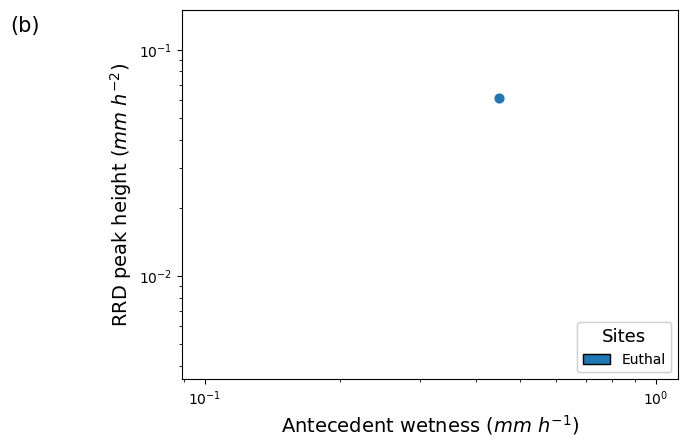

In [19]:
fig, axs = plt.subplots(1, 1)

stratify_precip=False
weighted=False
results_name_folder = 'results/detailedresults/'.format(site)


if stratify_precip:
    for j in range(5):
        show_vs_antecedent_wetness(axs, path, all_GISID, filter_bin_precip=[j], weighted=weighted, log_ordo=False, show_GAMCR=True, stats2show=['peak'], figsave=os.path.join(path, 'NRF_peak.png'), results_name_folder='results_{0}_paper_allprecip'.format(mode))
else:
    show_vs_antecedent_wetness(axs, path, all_GISID, markersize=40, filter_bin_precip=[j for j in range(5)], weighted=weighted, log_ordo=False, show_GAMCR=True, stats2show=['peak'], figsave=os.path.join(path, 'NRF_peak.png'), results_name_folder=results_name_folder)
axs.text(0.037,0.12, '(b)', fontsize=15)
axs.set_ylim(0.0035,0.15)
axs.set_xscale('log')
axs.set_yscale('log')
legend_patches = []
for ii, GISID in enumerate(all_GISID):
    if len(legend_patches) < len(all_GISID):
        legend_patches.append(Patch(facecolor=colors[ii], edgecolor='black', label=GISID2name[GISID]))

# Add the GISID color blocks to the legend
gisid_legend = axs.legend(handles=legend_patches, loc='lower right',  title='Sites', fontsize=10, title_fontsize=13)
axs.add_artist(gisid_legend)  # Add GISID legend manually so it doesn't get overwritten
if stratify_precip:
    method_legend_lines = []
    markers = ['o','^','s',"P",'*']
    labels = ['very low', 'low', 'standard', 'high', 'very high']
    for j in range(5):
        method_legend_lines.append(
        Line2D([0], [0], color='black', lw=linewidth, marker=markers[j], markersize=(j+1)*2, label=labels[j]),
        )
    method_legend = axs.legend(handles=method_legend_lines, loc=(0.,0.9), fontsize=11, title="Precipitation intensity", title_fontsize=13)

    
if stratify_precip:
    plt.savefig(os.path.join(path, 'RRD_peak_byprecip_antecedent_wetness.png'), dpi=200, bbox_inches='tight')
else:
    plt.savefig(os.path.join(path, 'RRD_peak_antecedent_wetness.png'), dpi=200, bbox_inches='tight')

# Timeseries figure showing the real-world Q timeseries modeled by GAMCR versus the measurements

In [22]:
from datetime import datetime, timedelta

# Given decimal years

# Function to convert decimal year to month
def decimal_year_to_month(decimal_year):
    year = int(decimal_year)  # Extract integer year
    remainder = decimal_year - year  # Get the fractional part
    days_in_year = 365.25  # Approximate days in a year
    days = remainder * days_in_year  # Convert fraction to days
    date = datetime(year, 1, 1) + timedelta(days=days)  # Convert to date
    return date.strftime("%B")  # Extract month name

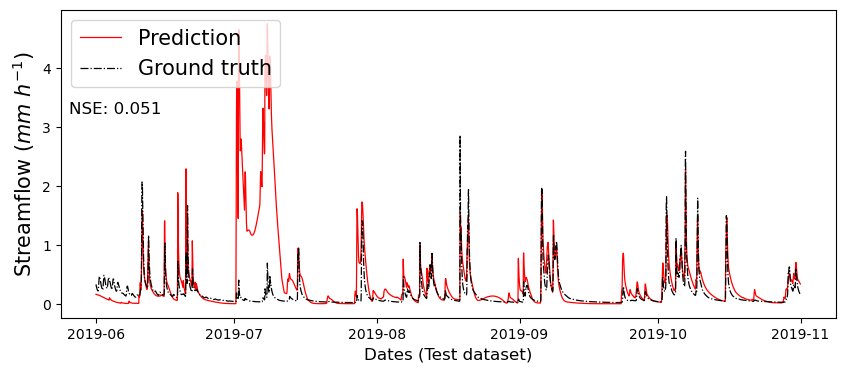

In [25]:
def filter_dates_fig(dates, site, all_data=False):
    dates = pd.to_datetime(dates)
    idxsyear = np.where( (np.array([date.year for date in dates])==2019) )[0]
    if site == '46':
        low_month = 7
        up_month = 9
    elif site in ['3','44','112']:
        low_month = 6
        up_month = 10
    else:
        low_month = 5
        up_month = 10
    idxsmonth_low = np.where(np.array([date.month for date in dates])>=low_month)[0]
    #np.where(dates.apply(lambda x: x.month>=low_month))[0]
    #idxsmonth_up = np.where(dates.apply(lambda x: x.month<=up_month))[0]
    idxsmonth_up = np.where(np.array([date.month for date in dates])<=up_month)[0]
    if not(all_data):
        idxs = np.intersect1d(idxsyear, idxsmonth_low)
    else:
        idxs = idxsmonth_low
    idxs = np.intersect1d(idxs, idxsmonth_up)
    return idxs


for ii in range(len(all_GISID)):
    GISID = all_GISID[ii]
    fig, axs = plt.subplots(1, 1, figsize=(10,4))
    df = pd.read_csv(os.path.join(path, GISID, 'data_'+GISID+'.txt'))
    idxs = filter_dates_fig(df['date'].to_numpy(), GISID)
    Qtrue = df.iloc[idxs]['q'].to_numpy()
        
    dates_true = df.iloc[idxs]['timeyear'].to_numpy()
    Qhat = np.load(os.path.join(path, GISID, 'results/detailedresults', 'predicted_streamflow.npy')).reshape(-1)
    
    dates = np.load(os.path.join(path, GISID, 'results/detailedresults', 'dates.npy')).reshape(-1)
    
    #idxs = np.where(dates>=2018)[0]
    idxs = filter_dates_fig([GAMCR.fractional_year_to_datetime(date) for date in dates], GISID)
    ########## Streamflow time series
    # Estimated streamflow using the model trained on the site considered
    months = [GAMCR.fractional_year_to_datetime(dy) for dy in dates[idxs]]
    axs.plot(months, Qhat[idxs], label='Prediction', lw=0.9, color='red')
    months = [GAMCR.fractional_year_to_datetime(dy) for dy in dates_true]
    axs.plot(months, Qtrue, label='Ground truth', lw=0.9, linestyle='-.', color='black')
    axs.legend(loc='upper left', fontsize=15)
    plt.ylabel('Streamflow ($mm$ $h^{-1}$)', fontsize=15)
    plt.xlabel('Dates (Test dataset)', fontsize=12)

    n = np.min([len(idxs),len(Qtrue)])
    axs.text(.01, .70, 'NSE: {:.3f}'.format(nse( Qhat[idxs][:n], Qtrue[:n] )), size=12,color='black',ha='left', va='top', transform=axs.transAxes)
    plt.savefig(os.path.join(path, 'reproduced_hydrograph_GISID_{0}.png'.format(GISID2name[GISID])), dpi=200, bbox_inches='tight') 

    plt.show()


# Studying correlation between antecedent wetness and precipitation intensity

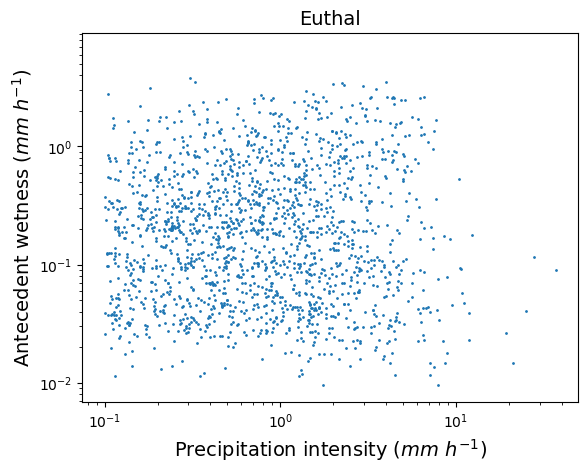

In [28]:
def filter_dates(GISID, dates):
    idxsyear = np.where(np.array([date.year for date in dates])<2018)[0]
    if GISID == '46':
        low_month = 7
        up_month = 9
    elif GISID in ['3','44','112']:
        low_month = 6
        up_month = 10
    else:
        low_month = 5
        up_month = 10
    idxsmonth_low = np.where(np.array([date.month for date in dates])>=low_month)[0]
    #np.where(dates.apply(lambda x: x.month>=low_month))[0]
    #idxsmonth_up = np.where(dates.apply(lambda x: x.month<=up_month))[0]
    idxsmonth_up = np.where(np.array([date.month for date in dates])<=up_month)[0]
    idxs = np.intersect1d(idxsyear, idxsmonth_low)
    idxs = np.intersect1d(idxs, idxsmonth_up)
    return idxs


for GISID in all_GISID:
    model = GAMCR.model.GAMCR()
    GISIDpath = os.path.join(path, str(GISID), 'data')
    X, matJ, y, timeyear, dates = model.load_data(GISIDpath, max_files=99)
    dates = pd.to_datetime(dates)
    idxs = filter_dates(GISID, dates)
    X = X[idxs,:]
    matJ = matJ[idxs,:,:]
    timeyear = timeyear[idxs]
    dates = dates[idxs]
    y = y[idxs]
    plt.figure()
    plt.scatter(X[1:,0], y[:-1], s=1)
    plt.title(GISID2name[GISID], fontsize=14) 
    plt.ylabel('Antecedent wetness ($mm$ $h^{-1}$)', fontsize=14)
    plt.xlabel('Precipitation intensity ($mm$ $h^{-1}$)', fontsize=14)
    plt.yscale('log')
    plt.xscale('log')
    plt.savefig(os.path.join(path, 'antecedent_wetness_vs_precip_{0}.png'.format(GISID)), dpi=200, bbox_inches='tight')
    plt.show()